---
title: High-dimensional data preparation
teaching: 45
exercises: 2
keypoints:
- ""
objectives:
- "Know how to deal with skewed a target variable, outliers, missing values, and categorical data"
- "Understand the importance of standarizing predictor variables"
questions:
- "How should we prepare a high-dimensional dataset for modeling and analysis?"
---

### Some feedback from Chris

* Please add an intro text section that transitions from previous 2 episodes to this one. E.g., "Let's turn our attention back towards the full high-dimensional Ames housing dataset. Before deciding which features to focus our modeling efforts on, we need to perform several preprocessing steps including..."
* I would maybe end this episode with how to handle the target variable, and focus on the predictors first. When discussing log transformation of the target and correcting for skew, we can be brief as this topic is mentioned in the preceding episodes
* Add a helper function that does all of the high-dimensional preprocessing steps included in this episode (to be called in downstream episodes)

### Load the data

In [1]:
## Ames housing dataset. 

# See here for thorough documentation regarding the feature set: 
# https://www.openml.org/d/42165
from sklearn.datasets import fetch_openml
housing = fetch_openml(name="house_prices", as_frame=True)

In [2]:
# add blanks between 
print(f"housing['data'].shape = {housing['data'].shape}\n") # 80 features total, 1460 observations
print(f"housing['feature_names'] = {housing['feature_names']}\n")
print(f"housing['target_names'] = {housing['target_names']}\n")

housing['data'].shape = (1460, 80)

housing['feature_names'] = ['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond', 'PavedDrive', 'WoodDeckSF', 'OpenPorchSF', 'E

In [3]:
# Extract X and y
X=housing['data']
y=housing['target']


In [4]:
X.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1.0,60.0,RL,65.0,8450.0,Pave,None,Reg,Lvl,AllPub,...,0.0,0.0,None,None,None,0.0,2.0,2008.0,WD,Normal
1,2.0,20.0,RL,80.0,9600.0,Pave,None,Reg,Lvl,AllPub,...,0.0,0.0,None,None,None,0.0,5.0,2007.0,WD,Normal
2,3.0,60.0,RL,68.0,11250.0,Pave,None,IR1,Lvl,AllPub,...,0.0,0.0,None,None,None,0.0,9.0,2008.0,WD,Normal
3,4.0,70.0,RL,60.0,9550.0,Pave,None,IR1,Lvl,AllPub,...,0.0,0.0,None,None,None,0.0,2.0,2006.0,WD,Abnorml
4,5.0,60.0,RL,84.0,14260.0,Pave,None,IR1,Lvl,AllPub,...,0.0,0.0,None,None,None,0.0,12.0,2008.0,WD,Normal


#### Plotting the target variable distribution
Explore the distribution of sale prices. Is the distribution uniform or skewed left/right?

Mean Sale Price: 180921.19589041095
Standard Deviation: 79415.29188606751


/usr/local/anaconda3/envs/high_dim_data/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


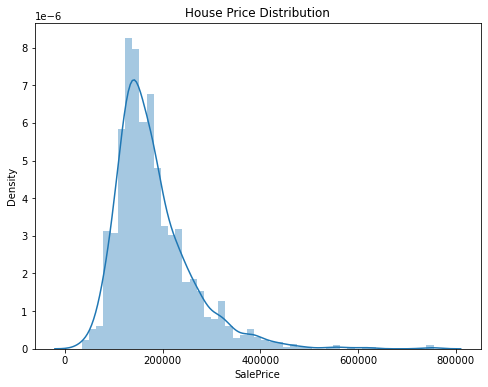

In [5]:
# plot histogram of housing sales, show mean and std of prices as well
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8,6))
sns.distplot(y)
title = plt.title('House Price Distribution')
print('Mean Sale Price:', np.mean(y))
print('Standard Deviation:', np.std(y))

#### Skewed Target Variable
This distribution has a long right tail, suggesting that it is skewed. 

Why do we care if the data is skewed? If the response variable is right skewed, the model will be trained on a much larger number of moderately priced homes, and will be less likely to successfully predict the price for the most expensive houses. In addition, the presence of a highly skewed target varible can, more likely, influence the distribution of residuals making them, in turn, non-normal. Normal residuals are required for hypothesis testing.

The concept is the same as training a model on imbalanced categorical classes. If the values of a certain independent variable (feature) are skewed, depending on the model, skewness may violate model assumptions (e.g. logistic regression) or may impair the interpretation of feature importance.

In [6]:
# To quantitatively assess a distribution's skewness, we can use pandas' skew() function
y.skew() 

1.8828757597682129

· If the skewness is between -0.5 and 0.5, the data are fairly symmetrical

· If the skewness is between -1 and — 0.5 or between 0.5 and 1, the data are moderately skewed

· If the skewness is less than -1 or greater than 1, the data are highly skewed

#### Correcting skewed target variable using log transformation
We can correct for a skewed variable by adjusting the scale of the variable. One commonly used rescaling technique that can correct for skew is applying a log transformation. 

/usr/local/anaconda3/envs/high_dim_data/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


12.024050901109373
0.3993150462437029


0.12133506220520406

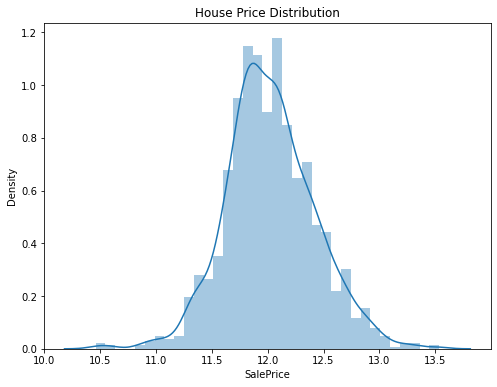

In [7]:
# Correct for skew using log transformation
y = np.log(y)
plt.figure(figsize=(8,6))
sns.distplot(y)
title = plt.title("House Price Distribution")
print(np.mean(y))
print(np.std(y))
y.skew()

Our data now appears to be normal and has a skew value of only .399 — meaning the data is now fairly symmetrical. When we correct the target variable skew using a log transformation but not the predictors, the resulting model fit to this data is a log-linear model, meaning a log dependent variable with linear explanatory variables. 

**Note on other skew correction methods**: While a log transformation is probably the most common way to fix a skewed variable, there are other rescaling methods available to explore, e.g., Box Cox transformation.

#### Skewed Predictor Variables
What happens if our predictor variables are also skewed? Does this have any impact on the model, and should we correct for predictor variable skew?

Technically speaking, the only distributional assumption we have to look out for when doing hypothesis testing with linear models is that the model's residuals are normally distributed. As long as this is true, the underlying independent variable can be as non-normal as you like. However, sometimes the presence of skewed predictors can lead to less stable model predictions because long tails or outliers in the predictor variable distrutions require an analsyis of leverage (i.e. how much these outliers impact on the estimate of the regression coefficients).

Thus, for very skewed variables it might be a good idea to transform the data to eliminate the harmful effects. If there's just a small amount of skew, you likely are fine to move forward with the data as is. We will return to the impact of skewed predictor variables later in the lesson. For now, we will leave all predictor variables as they are.

### Code all nominal and dichotomous variables as "dummy variables" via one-hot encoding

In [8]:
X.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1.0,60.0,RL,65.0,8450.0,Pave,None,Reg,Lvl,AllPub,...,0.0,0.0,None,None,None,0.0,2.0,2008.0,WD,Normal
1,2.0,20.0,RL,80.0,9600.0,Pave,None,Reg,Lvl,AllPub,...,0.0,0.0,None,None,None,0.0,5.0,2007.0,WD,Normal
2,3.0,60.0,RL,68.0,11250.0,Pave,None,IR1,Lvl,AllPub,...,0.0,0.0,None,None,None,0.0,9.0,2008.0,WD,Normal
3,4.0,70.0,RL,60.0,9550.0,Pave,None,IR1,Lvl,AllPub,...,0.0,0.0,None,None,None,0.0,2.0,2006.0,WD,Abnorml
4,5.0,60.0,RL,84.0,14260.0,Pave,None,IR1,Lvl,AllPub,...,0.0,0.0,None,None,None,0.0,12.0,2008.0,WD,Normal


In [9]:
from helper_functions import encode_predictors_housing_data
X_encoded = X.copy(deep=True) 
X_encoded = encode_predictors_housing_data(X_encoded)
X_encoded.head()

,MSSubClass_20.0,MSSubClass_30.0,MSSubClass_40.0,MSSubClass_45.0,MSSubClass_50.0,MSSubClass_60.0,MSSubClass_70.0,MSSubClass_75.0,MSSubClass_80.0,MSSubClass_85.0,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,YrSold,MoSold,Street,CentralAir
0,0,0,0,0,0,1,0,0,0,0,...,0.0,61.0,0.0,0.0,0.0,0.0,2008.0,2.0,1,1
1,1,0,0,0,0,0,0,0,0,0,...,298.0,0.0,0.0,0.0,0.0,0.0,2007.0,5.0,1,1
2,0,0,0,0,0,1,0,0,0,0,...,0.0,42.0,0.0,0.0,0.0,0.0,2008.0,9.0,1,1
3,0,0,0,0,0,0,1,0,0,0,...,0.0,35.0,272.0,0.0,0.0,0.0,2006.0,2.0,1,1
4,0,0,0,0,0,1,0,0,0,0,...,192.0,84.0,0.0,0.0,0.0,0.0,2008.0,12.0,1,1


### Remove columns/predictors that meet any of the following criteria...
* Presence of one or more NaN value (note: interpolation is also an option here)
* Column is a constant or nearly constant (i.e., one value is present across 90% or more of the rows). Constant predictors have no prediction power, and low-variance predictors have very little prediction power.

In [10]:
# Remove variables that have NaNs as observations and vars that have a constant value across all observations
from helper_functions import remove_bad_cols
X_encoded_good = remove_bad_cols(X_encoded, .95)
X_encoded_good.head()


MSSubClass_30.0 removed due to lack of variance ( >95.0% rows have the same value value)
MSSubClass_40.0 removed due to lack of variance ( >95.0% rows have the same value value)
MSSubClass_45.0 removed due to lack of variance ( >95.0% rows have the same value value)
MSSubClass_70.0 removed due to lack of variance ( >95.0% rows have the same value value)
MSSubClass_75.0 removed due to lack of variance ( >95.0% rows have the same value value)
MSSubClass_80.0 removed due to lack of variance ( >95.0% rows have the same value value)
MSSubClass_85.0 removed due to lack of variance ( >95.0% rows have the same value value)
MSSubClass_90.0 removed due to lack of variance ( >95.0% rows have the same value value)
MSSubClass_160.0 removed due to lack of variance ( >95.0% rows have the same value value)
MSSubClass_180.0 removed due to lack of variance ( >95.0% rows have the same value value)
MSSubClass_190.0 removed due to lack of variance ( >95.0% rows have the same value value)
MSZoning_C (all) r

,MSSubClass_20.0,MSSubClass_50.0,MSSubClass_60.0,MSSubClass_120.0,MSZoning_RL,MSZoning_RM,LandContour_Lvl,LotConfig_Corner,LotConfig_CulDSac,LotConfig_Inside,...,Fireplaces,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,ScreenPorch,YrSold,MoSold,CentralAir
0,0,0,1,0,1,0,1,0,0,1,...,0.0,2.0,548.0,0.0,61.0,0.0,0.0,2008.0,2.0,1
1,1,0,0,0,1,0,1,0,0,0,...,1.0,2.0,460.0,298.0,0.0,0.0,0.0,2007.0,5.0,1
2,0,0,1,0,1,0,1,0,0,1,...,1.0,2.0,608.0,0.0,42.0,0.0,0.0,2008.0,9.0,1
3,0,0,0,0,1,0,1,1,0,0,...,1.0,3.0,642.0,0.0,35.0,272.0,0.0,2006.0,2.0,1
4,0,0,1,0,1,0,1,0,0,0,...,1.0,3.0,836.0,192.0,84.0,0.0,0.0,2008.0,12.0,1


**Note**: can replace NaNs with some interpolation instead of dropping columns. Your definition of bad may and possibly should differ!

#### End of data cleaning stage
At this point, we have prepared our X dataframe to contain all independent variables of interest. Our Y variable (pands series object) contains only the response/dependent variable we are trying to predict -- housing prices. 

In [11]:
# quick check of data-types and dimensions post-cleaning efforts
print(X_encoded_good.shape)
print(y.shape)

(1460, 82)
(1460,)


## Train Test Split

In [12]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_encoded_good, y, test_size=0.25)

In [13]:
X_train

,MSSubClass_20.0,MSSubClass_50.0,MSSubClass_60.0,MSSubClass_120.0,MSZoning_RL,MSZoning_RM,LandContour_Lvl,LotConfig_Corner,LotConfig_CulDSac,LotConfig_Inside,...,Fireplaces,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,ScreenPorch,YrSold,MoSold,CentralAir
719,1,0,0,0,1,0,1,0,0,1,...,1.0,1.0,300.0,0.0,0.0,0.0,0.0,2006.0,5.0,1
1438,1,0,0,0,0,1,1,0,0,1,...,0.0,2.0,923.0,0.0,158.0,158.0,0.0,2010.0,4.0,1
219,0,0,0,1,1,0,1,0,0,1,...,0.0,2.0,438.0,108.0,0.0,0.0,0.0,2006.0,3.0,1
123,0,0,0,1,1,0,1,0,0,1,...,0.0,2.0,530.0,0.0,63.0,0.0,0.0,2008.0,3.0,1
747,0,0,0,0,0,1,1,1,0,0,...,1.0,4.0,864.0,181.0,0.0,386.0,0.0,2009.0,5.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
816,1,0,0,0,1,0,1,1,0,0,...,1.0,1.0,275.0,0.0,0.0,120.0,0.0,2006.0,7.0,1
152,0,0,1,0,1,0,1,0,1,0,...,1.0,2.0,495.0,0.0,66.0,0.0,0.0,2006.0,6.0,1
372,0,0,0,1,1,0,1,0,0,1,...,0.0,1.0,264.0,353.0,0.0,0.0,90.0,2010.0,2.0,1
283,1,0,0,0,1,0,1,0,0,1,...,1.0,3.0,898.0,210.0,150.0,0.0,0.0,2009.0,12.0,1


## Use means and stds from training data to zscore test data

In [14]:
import pandas as pd

def zscore(df: pd.DataFrame, train_means: pd.Series, train_stds: pd.Series) -> pd.DataFrame:
    """return z-scored dataframe"""
    return (df - train_means) / train_stds

In [15]:
# get means and stds
train_means = X_train.mean()
train_stds = X_train.std()

In [16]:
X_train_z = zscore(df=X_train, train_means=train_means, train_stds=train_stds)
X_test_z = zscore(df=X_test, train_means=train_means, train_stds=train_stds)

X_test_z.head()

,MSSubClass_20.0,MSSubClass_50.0,MSSubClass_60.0,MSSubClass_120.0,MSZoning_RL,MSZoning_RM,LandContour_Lvl,LotConfig_Corner,LotConfig_CulDSac,LotConfig_Inside,...,Fireplaces,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,ScreenPorch,YrSold,MoSold,CentralAir
648,-0.749360,-0.33064,1.960005,-0.255178,0.523915,-0.431484,0.344064,-0.466713,-0.267139,0.626714,...,0.592168,0.298968,-0.140253,-0.752285,1.164434,3.048666,-0.277032,1.655085,-0.141073,0.263197
1379,-0.749360,-0.33064,-0.509737,-0.255178,0.523915,-0.431484,0.344064,-0.466713,-0.267139,0.626714,...,-0.944381,0.298968,-0.335602,0.036236,-0.711826,-0.366205,-0.277032,0.140402,-0.510629,0.263197
739,-0.749360,-0.33064,1.960005,-0.255178,0.523915,-0.431484,0.344064,-0.466713,-0.267139,0.626714,...,-0.944381,0.298968,0.464399,0.722249,0.135517,-0.366205,-0.277032,0.897743,-0.880185,0.263197
401,1.333253,-0.33064,-0.509737,-0.255178,0.523915,-0.431484,0.344064,-0.466713,-0.267139,0.626714,...,0.592168,0.298968,-0.335602,-0.752285,-0.711826,-0.366205,-0.277032,-1.374280,0.228484,0.263197
375,-0.749360,-0.33064,-0.509737,-0.255178,0.523915,-0.431484,-2.903782,-0.466713,-0.267139,0.626714,...,-0.944381,-2.341111,-2.196069,-0.752285,-0.711826,-0.366205,-0.277032,0.897743,-1.249742,-3.795967


### plot of distribution before/after

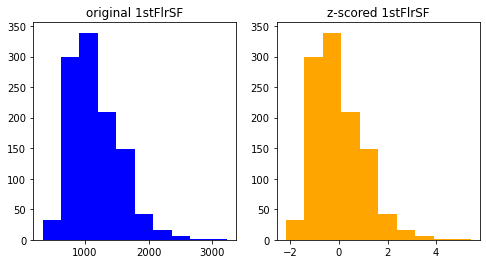

In [17]:
# choose column
column = '1stFlrSF'

# plot
fig, axs = plt.subplots(1,2, figsize=(8,4))
plot_configs = zip(
    axs, 
    [X_train, X_train_z], 
    ["blue", "orange"], 
    [f"original {column}", f"z-scored {column}"]
) 
for (ax, df, color, title) in plot_configs:
    ax.hist(df[column], color=color)
    ax.set_title(title) 

plt.show()


#### Should we standardize the target variable as well?
In the context of linear modeling using OLS, standardizing the target varible is not necessary. Standardization of target variables is a common practice used when models make use of gradient descent to solve for the model parameters. Gradient descent tends to converge much faster if the target variable has a smaller range. 
